# Practical 04 Part A - Preparing Our Data

In this practical, we will be using the Clothing Co-Parsing dataset that has already provided the segmentation maps for a variety of different types of apparel.
    https://github.com/bearpaw/clothing-co-parsing
    
But in our application, we will just want to different top/bottom clothing worn on the body, but exclude accessories, bags, shoes and headwear. So when we load the data from the dataset, we will re-map the categorization to our own categories as described below.

Before you start the data preparation, be sure to run the following to initialize your conda environment.

```
conda install numpy
conda install scikit-learn
conda install tensorflow
conda install opencv
conda install matplotlib
conda install -c anaconda scikit-image
conda install scipy
```

## 4.1.1 Download the Dataset and Set Up Folders

Download the latest Clothing Co-Parsing (CCP) Dataset from Github here:

https://github.com/bearpaw/clothing-co-parsing

You may also download the same dataset from Polymall.


## 4.1.2 Set Up Paths to Your Training Data and Output

In the code below, set up the paths to your training data and output folders.


In [1]:
import os 

# TODO: 
# Set up your folder containing the data to your Clothing dataset
#
clothes_folder = os.path.expanduser("~") + '/Downloads/clothing-co-parsing-master/'
output_folder = os.path.expanduser("~") + '/data/p4/'


## 4.1.3 Set Up Some Methods and Load the CCP Labels

Run the following cell below to declare some methods and load up the labels used by the CCP dataset.

The dataset is provided using a MATLAB file format. Fortunately, we have a library provided within SciPy that is available and allows us to read and process MATLAB files.



In [2]:
import numpy as np
import scipy.io
import pandas
from matplotlib import pyplot as plt
from matplotlib import cm
import cv2

# Loads an image using OpenCV and returns the result
# in a numpy array in R, G, B order.
#
def loadimage(filename):
    img = cv2.imread(filename)
    img = img[...,::-1]     #reverse the RGB
    return img

# Resizes an image using OpenCV and returns the result
# in a numpy array in R, G, B order.
#
def resizeimage(img, width, height, nearest):
    if nearest:
        return cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    else:
        return cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)

# Loads a MATLIB file
#
def loadmat(filename):
    mat = scipy.io.loadmat(filename)  # load mat-file
    return mat
    
# Load the label list and print them out
#
mat = scipy.io.loadmat(clothes_folder + 'label_list.mat')
labels = []
for label in mat['label_list'][0]:
    labels.append(label[0])
for index in range(0, len(labels)):
    print ("%2d: %s" % (index, labels[index]))



 0: null
 1: accessories
 2: bag
 3: belt
 4: blazer
 5: blouse
 6: bodysuit
 7: boots
 8: bra
 9: bracelet
10: cape
11: cardigan
12: clogs
13: coat
14: dress
15: earrings
16: flats
17: glasses
18: gloves
19: hair
20: hat
21: heels
22: hoodie
23: intimate
24: jacket
25: jeans
26: jumper
27: leggings
28: loafers
29: necklace
30: panties
31: pants
32: pumps
33: purse
34: ring
35: romper
36: sandals
37: scarf
38: shirt
39: shoes
40: shorts
41: skin
42: skirt
43: sneakers
44: socks
45: stockings
46: suit
47: sunglasses
48: sweater
49: sweatshirt
50: swimwear
51: t-shirt
52: tie
53: tights
54: top
55: vest
56: wallet
57: watch
58: wedges


## 4.1.4 Re-Mapping to Own Classification

Run the following cell to set up the map to our own classification.

In our application, we are only going to do style transfer to pixels identified as clothing, ignoring everything else. 

So we are going to combine classifications like blouses, blazers into a single 'top' label; jeans and leggings into a single 'bottom' label, and bodysuits and dresses into a single 'onepiece' label.


In [3]:
renamed_labels = ['null', 'top', 'bottom', 'onepiece']
num_classes = len(renamed_labels)

belong_to_top_labels = ['blouse', 'blazer', 'bra', 'cape', 'cardigan', 'coat', 'hoodie', 'jacket', 'jumper', 'shirt', 'short', 'suit', 'sweater', 'sweatshirt', 't-shirt', 'top', 'vest']
belong_to_bottom_labels = ['jeans', 'leggings', 'panties', 'pants', 'shorts', 'skirt', 'stockings', 'tights']
belong_to_onepiece_labels = ['bodysuit', 'dress', 'intimate', 'romper', 'swimwear']



## 4.1.5 Method to Load Image and its Segmentation Map

Run the following cell to declare methods to load up both the source image and the corresponding segmentation map.  The method that loads the segmentation map accepts both a MATLAB file, or a R/G/B PNG file format as its input. To annotation an image with a segmentation map, you can use any image processing tool (such as Photoshop) to construct the PNG image, such that each pixel R/G/B pixel value corresponds to the class index of that pixel.

*NOTE: The CCP dataset provides all segmentation maps in an array stored in a MATLAB file format.*

In [4]:
# Loads and resize the image down to a size that can
# be fed into our segmentation network.
#
def load_and_process_image(filename, width, height):
    if not (os.path.exists(clothes_folder + 'photos/' + filename + ".jpg")):
        return None
    
    img = loadimage(clothes_folder + 'photos/' + filename + ".jpg")
    img = resizeimage(img, width, height, False)                   # Bicubic interpolation    
    return img


# Loads and resize the segmentation down to a size that can
# be fed into our segmentation network.
#
# The segmentation map can either be a MATLAB file, or a PNG
# file. 
#
def load_and_process_segmentation_map(filename, width, height):
    matlab_file = clothes_folder + 'annotations/pixel-level/' + filename + '.mat'
    png_file = clothes_folder + 'annotations/pixel-level/' + filename + '.png'
    
    if not (os.path.exists(matlab_file) or os.path.exists(png_file)):
        return None
    
    if (os.path.exists(matlab_file)):
        mat = loadmat(matlab_file)
        seg = resizeimage(mat['groundtruth'], width, height, True)     # Nearest neighbour
        
    else:
        # Must be an RGB PNG file.
        # 
        mat = cv2.imread(png_file)
        seg = resizeimage(mat, width, height, True)     # Nearest neighbour
        
        # At least one of the R,G,B channels will store the value
        # of the segmentation index. So we take the max of all channels.
        #
        seg = np.max(seg, axis=2)

    return seg
    

## 4.1.6 Method to Reclassify Original CCP Pixels

Run the following cell to declare a method to reclassify the original CCP pixels into the following classes:
0. Background 
1. Top Clothing
2. Bottom Clothin
3. One-Piece



In [5]:
# The data provided in the segmentation files are MATLAB files that stores
# the index of the identified object type for each pixel.
#
# We will also have to map the original index value into the our 
# classification, where:
#   0 - null
#   1 - top
#   2 - bottom
#   3 - onepiece
#
# For this index to be used for output classification, we will 
# have to convert it to a one-hot array and this is what this 
# function does.
#
def reclassify_segmentation(seg):
    result = np.zeros((seg.shape[0], seg.shape[1], num_classes), dtype=np.int8)
    resultmap = np.zeros((seg.shape[0], seg.shape[1]))
    
    for y in range(seg.shape[0]):
        for x in range(seg.shape[1]):
            idx = seg[y][x]
            this_label = labels[idx]
            this_label_idx = 0
            
            # Reclassifies the original label to top / bottom / one-piece
            #
            if this_label in belong_to_top_labels:
                this_label_idx = 1
            elif this_label in belong_to_bottom_labels:
                this_label_idx = 2
            elif this_label in belong_to_onepiece_labels:
                this_label_idx = 3
            else:
                this_label_idx = 0
            
            resultmap[y][x] = this_label_idx
            result[y][x][this_label_idx] = 1.0
            
    return (result, resultmap)
            

## 4.1.7 Exploring Our Segmentation Map

Let's load up an image and its corresponding segmentation map. The original segmentation map is then re-classified to our own mappings and then displayed in the Notebook output below.

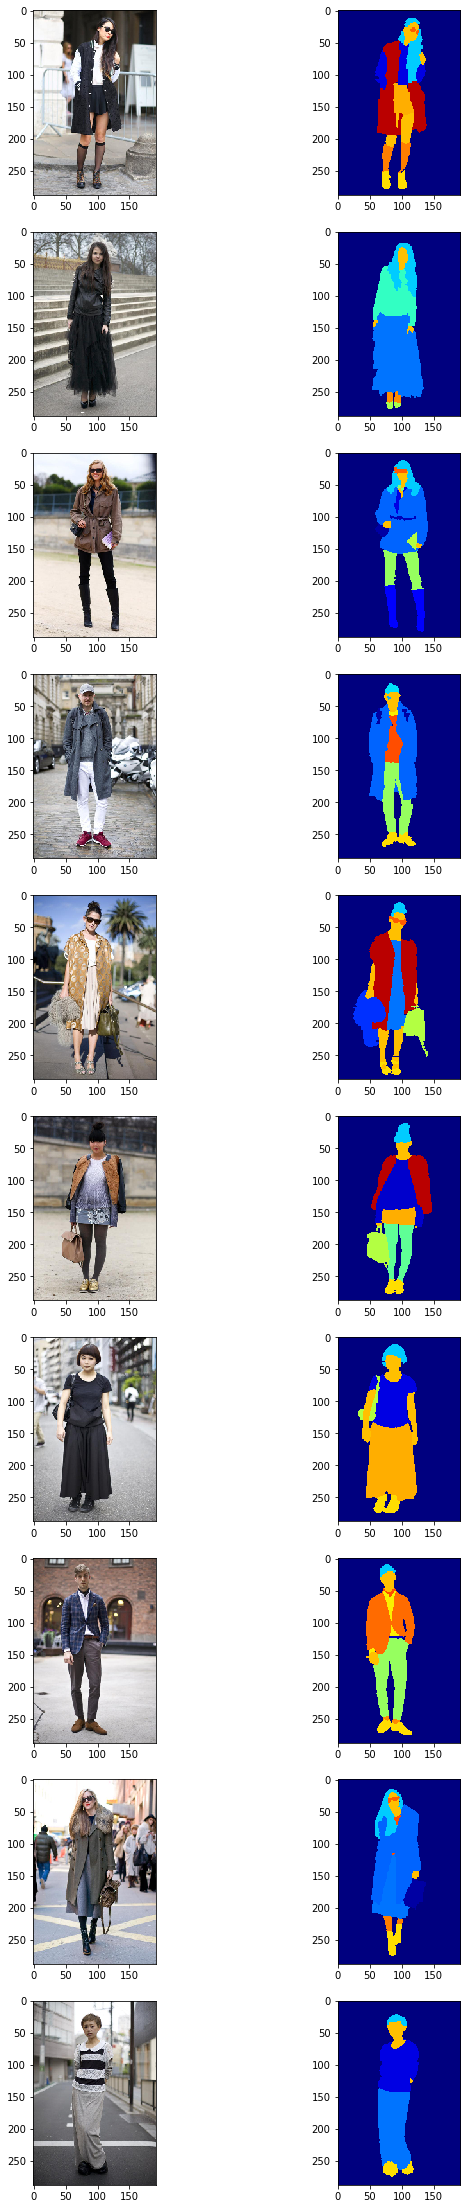

In [8]:
# Set a value for the start_index to indicate which image in the CCP folder
# to load. The loop below retrieves up to 10 images and their corresponding 
# segmentation map and displays them in the Notebook.
#
start_index = 1

plt.figure(figsize=(10,40))
for i in range(start_index, start_index + 10):
    
    test_file = "%04d" % (i)
    
    # Load and show image
    #
    plt.subplot(10, 2, (i - start_index) * 2 + 1)
    img = load_and_process_image(test_file, 192, 288)
    if not img is None: 
        plt.imshow(img)

    # Load segmentation map
    #
    plt.subplot(10, 2, (i - start_index) * 2 + 2)
    img = load_and_process_segmentation_map(test_file, 192, 288)
    
    if not img is None: 
        # Reclassify segmentation map
        #
        # seg, img = reclassify_segmentation(img)
        
        # Place this pixel of 4 that the matplot normalization 
        # will give us consistent colors for all the segmentation maps
        #
        img[0,0] = 58
        
        # Show the segmentation map
        #
        plt.imshow(img, norm=None, cmap=cm.jet)
    

plt.show()

## 4.1.8 Read and Process the Images

Here we will load up all the images and prepare the data for uploading to Google Drive. Fill in the necessary codes below to load the image file, load the segmentation map, convert the segmentation map to one-hot vectors, and finally save the collection of arrays into a file.

In [9]:
os.makedirs(output_folder + 'x/', exist_ok=True)
os.makedirs(output_folder + 'y/', exist_ok=True)


# Set up the number of photos, width and height that we will be downsizing
# the photos to. Larger photos will require longer time to train and
# perform neural transfer!
#
num_of_photos = 2000
width = 192
height = 288

x = []
y = []


print ("Processing...")

batch_no = 0

# Here, we load all photos and process them one by one.
#
for i in range(1, num_of_photos + 1):
    
    fname = '%04d' % i
    
    # TODO:
    # Load the image file, process and save it into the x / y lists.
    #
    #...#
    img = load_and_process_image(fname, width, height)
    seg = load_and_process_segmentation_map(fname, width, height)
    
    if img is None or seg is None:
        continue

    x.append(img)

    seg, segmap = reclassify_segmentation(seg)
    y.append(seg)

    # Save the data in groups of 50.
    #
    if i % 50 == 0:
        print ("Saving batch #%d..." % batch_no)
        
        # Convert to Numpy arrays and reshape them
        #
        x = np.array(x)
        y = np.array(y)
        y = y.reshape(y.shape[0], y.shape[1], y.shape[2], num_classes)
        print (x.shape)
        print (y.shape)

        # Save the batch
        #
        np.save(output_folder + 'x/%d.npy' % (batch_no), x)
        np.save(output_folder + 'y/%d.npy' % (batch_no), y)
        
        x = []
        y = []
        
        batch_no = batch_no + 1

        
# Save the last group
#
print ("Saving batch #%d..." % batch_no)

# Convert to Numpy arrays and reshape them
#
x = np.array(x)
y = np.array(y)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], num_classes)
print (x.shape)
print (y.shape)

# Save the batch
#
np.save(output_folder + 'x/%d.npy' % (batch_no), x)
np.save(output_folder + 'y/%d.npy' % (batch_no), y)

print ("Processing complete.")

Processing...
Saving batch #0...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #1...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #2...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #3...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #4...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #5...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #6...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #7...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #8...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #9...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #10...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #11...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #12...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #13...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #14...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #15...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #16...
(50, 288, 192, 3)
(50, 288, 192, 4)
Saving batch #17...
(50, 288, 192, 3)
(50, 2

## 4.1.9 Following Up...

Once you have generated *.npy files:

1. Upload them to the Google Drive into a Data/D4 folder. The folder should look like the following structure:
   - Data
     - D4
       - x
       - y

2. Then, upload the practical-04b and practical-04c files to your Google Colab folder on Google Drive.